In [17]:
from __future__ import print_function, division

%matplotlib inline
%precision 3
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import random
import networkx as nx
import numpy as np
import copy

import thinkplot
import thinkstats2

In [18]:
class Student(object):
    """ 
    Base student; used as node in network. 
    """

    def __init__(self, immune_strength=5, tolerance=50):
        self.immune_strength = immune_strength #rate of lowering exposure
        self.tolerance = tolerance # value at which is_sick
        self.exposure = 0
        self.is_sick = 0 # 0: not sick; 1: sick; 2: was sick already
        
    def process_exposure(self):
        if self.is_sick == 2:
            return
        self.exposure -= self.immune_strength
        
        if self.is_sick == 1:
            if self.exposure <= 0:
                self.is_sick = 2
        elif self.is_sick == 0:
            if self.exposure >= self.tolerance:
                self.is_sick = 1


In [36]:
class MeaslesStudent(object):
    """ 
    Base student with measles (an asymptomatic infectious step); used as node in network. 
    """

    def __init__(self, immune_strength=5, tolerance=50, totalUnaware=1):
        self.immune_strength = immune_strength #rate of lowering exposure
        self.tolerance = tolerance # value at which is_sick
        self.exposure = 0
        self.is_sick = 0 # 0: not sick; 1: sick; 2: was sick already; 3: infectious but unaware
        self.days_unaware = 0
        self.total_unaware = totalUnaware 
        
    def process_exposure(self):
        if self.is_sick == 2:
            return
        self.exposure -= self.immune_strength
        
        if self.is_sick == 1:
            if self.exposure <= 0:
                self.is_sick = 2
        elif self.is_sick == 0:
            if self.exposure >= self.tolerance:
                self.is_sick = 3
        elif self.is_sick == 3:
            self.days_unaware += 1
            if self.days_unaware >= self.total_unaware:
                self.is_sick = 1

In [42]:
def create_student_ba_graph(size=100, new_edges_per_node=4, roommate=True):
    """ 
    Creates a graph of [size] Student nodes, using weighted connections.
    Returns two graphs - the first, of Measles students, and the second, of non-measles students.
    """
    G = nx.Graph()
    if size <= 0:
        return G
    
    first_student = MeaslesStudent()
    G.add_node(first_student)
    
    students_list = []
    students_list.append([first_student,0])

    #Build the BA graph.
    for i in range(size):
        im = random.randint(4,8)
        tol = random.randint(40,80)
        new_student = MeaslesStudent(
            immune_strength = im, 
            tolerance = tol,
            totalUnaware = 4);
        G.add_node(new_student)
        all_students = range(len(students_list))
        probs_base = [float(k[1]+1) for k in students_list]
        probs = probs_base/np.sum(probs_base)
        number_of_friends = min(len(students_list), new_edges_per_node)
        new_friends = np.random.choice(all_students, size=number_of_friends, replace=False, p=probs)
        for friend in new_friends:
            students_list[friend][1] += 1
            G.add_edge(new_student, students_list[friend][0])
        students_list.append([new_student, nx.degree(G, new_student)])
 
    #Assign strength to edges.
    social = {}
    for edge in G.edges():
        social[edge] = random.randint(5,10)
    nx.set_edge_attributes(G, "social", social)
    
    #Create roommate pairs
    if roommate == True:       
        G = create_Roommates(G)
    
    #Create an identical network, but with Student nodes.
    F = G.copy()
    for node in F.nodes():
        im_s = int(node.immune_strength)
        tol = int(node.tolerance)
        node = Student(immune_strength = im_s, tolerance = tol)
    
    return F, G


def create_Roommates(G):
    '''Randomly pairs nodes in G as roommates.'''
    all_nodes = G.nodes()
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) // 2):
        first_roommate = all_nodes[2*i]
        second_roommate = all_nodes[(2*i) + 1]
        if not G.has_edge(first_roommate, second_roommate):
            G.add_edge(first_roommate, second_roommate)
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
        else:
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
    return G


def draw_sickness_graph(G, pos):
    """ 
    Draws a graph, with red as sick, 
    blue as recovered, 
    green as never sick. Colors aren't set in stone.
    """
    sick_nodes = [node for node in G.nodes() if node.is_sick == 1]
    recovered_nodes = [node for node in G.nodes() if node.is_sick == 2]
    healthy_nodes = [node for node in G.nodes() if node.is_sick == 0]

    nx.draw_networkx_nodes(G, pos, nodelist=sick_nodes, node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=healthy_nodes, node_color='g')
    nx.draw_networkx_nodes(G, pos, nodelist=recovered_nodes, node_color='b')
    nx.draw_networkx_edges(G, pos)
    plt.axis('off')
    plt.show()

In [43]:
#This cell contains two versions of the step function. Whichever 'step' points to will be the one used.
#Ideally, which is called would be controlled by a boolean, or an anonymized function would be passed.
#However, we didn't do that. Re-defining the function as-needed is a bit sketchy, but it works for practical purposes.

def step(G):
    """Step function for a generic disease - so, not measles."""
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += G[node][neighbor]["social"]
        elif node.is_sick == 1:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    return total_sick

def step(G, quarantine_factor = 2, measles_factor = 3):
    ''' Measles infectious step - 
    with is_sick=1, infects at (1/quarantine_factor)x rate.
    with is_sick=3 (infectious but unaware), infects at (measles_factor)x rate'''
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += (G[node][neighbor]["social"]/quarantine_factor) #todo: differentiate for student plain.
                if neighbor.is_sick == 3:
                    node.exposure += measles_factor*(G[node][neighbor]["social"])
                    
        elif node.is_sick == 1 or node.is_sick == 3:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    return total_sick

In [44]:
def run_graph(graph, iters):
    """Runs the graph for a certain number of iterations, returning a count of sick nodes over time."""
    #Always instantiate patient 0 as the first node, for consistency. 
    patient_zero = graph.nodes()[0]
    patient_zero.exposure = 100
    patient_zero.is_sick = 1

    sick = []
    time_step = []
    for i in range(iters):
        sick.append(step(graph))
        time_step.append(i)
    return sick, time_step

In [45]:
def run_trials_same_graph(G,F,iters,total):
    '''Runs a large number of trials for the same starting conditions (the input graphs), with randomized starting nodes.'''
    maxG = []
    maxF = []
    avgG = []
    avgF = []
    for i in range(total):
        sickG,time_stepG = run_graph(G.copy(),iters)
        sickF,time_stepF = run_graph(F.copy(),iters)
        maxG.append(max(sickG))
        maxF.append(max(sickF))
        avgG.append(sum(sickG)/len(sickG))
        avgF.append(sum(sickF)/len(sickF))
    return maxG,avgG,maxF,avgF

def run_trials_different_graphs(t_size = None, t_edges = None, roommate = True, iters = 50, total = 100):
    ''' Generates total graphs, each of iters steps for G (measles) and F (not measles), and returns maxG, avgG, maxF, avgF.
    Parameters don't currently do anything. '''
    maxG = []
    maxF = []
    avgG = []
    avgF = []
    for i in range(total):
        F, G = create_student_ba_graph()
        sickG,time_stepG = run_graph(G,iters)
        sickF,time_stepF = run_graph(F,iters)
        maxG.append(max(sickG))
        maxF.append(max(sickF))
        avgG.append(sum(sickG)/len(sickG))
        avgF.append(sum(sickF)/len(sickF))
    return maxG,avgG,maxF,avgF

def frequencyFinder(stats):
    ''' Helper function for CDF creation. Feed it a list of values, and get out the key-value pairs.'''
    res = {}
    for i in stats:
        if i not in res:
            res[i] = 1
        else:
            res[i] +=1
    
    keys = sorted(res.keys())
    values = []
    for key in keys:
        values.append(res[key])
    return keys,values
        


The following cells create sample graphs, like the ones in the project report. The extra function definitions are to deal with a known lack of modularity in our original code.

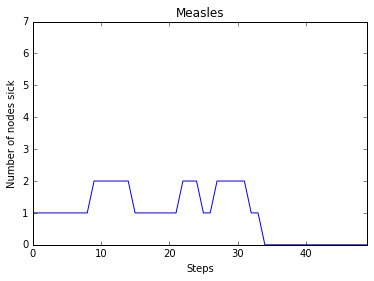

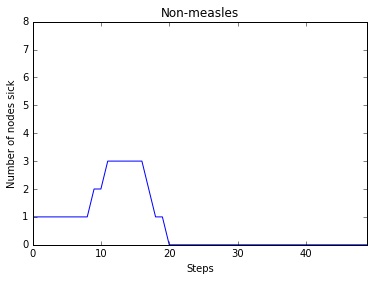

In [48]:
# This cell creates a plot of one run, measles vs. not-measles over time.
F, G = create_student_ba_graph()
measles_sick, measles_times = run_graph(G,50)

#Redefining the step and run functions, because our current version of the code isn't as modular as we'd like yet.
def step(G):
    """Step function for a generic disease - so, not measles."""
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += G[node][neighbor]["social"]
        elif node.is_sick == 1:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    return total_sick

def run_graph(graph, iters):
    """Runs the graph for a certain number of iterations, returning a count of sick nodes over time."""
    #Always instantiate patient 0 as the first node, for consistency. 
    patient_zero = graph.nodes()[0]
    patient_zero.exposure = 100
    patient_zero.is_sick = 1

    sick = []
    time_step = []
    for i in range(iters):
        sick.append(step(graph))
        time_step.append(i)
    return sick, time_step

nm_sick, nm_times = run_graph(F, 50)

plt.plot(measles_times, measles_sick)
plt.ylabel('Number of nodes sick')
plt.xlabel('Steps')
plt.axis([0, measles_times[-1], 0, max(measles_sick)+5])
plt.title('Measles')
plt.show()

plt.plot(nm_times, nm_sick)
plt.ylabel('Number of nodes sick')
plt.xlabel('Steps')
plt.axis([0, nm_times[-1], 0, max(nm_sick)+5])
plt.title('Non-measles')
plt.show()


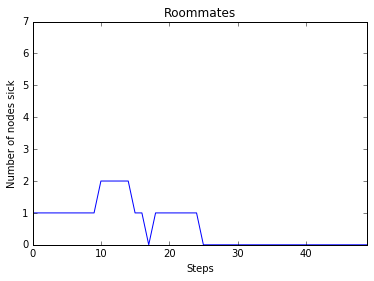

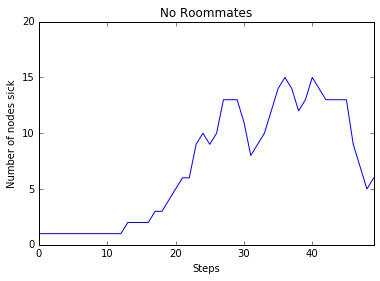

In [54]:
# This cell creates a plot of one run, roommate vs. not-roommate over time.

F, G = create_student_ba_graph(roommate = False)
G = None
G = create_Roommates(F.copy())

room_sick, room_times = run_graph(G, 50)
nr_sick, nr_times = run_graph(F, 50)


plt.plot(room_times, room_sick)
plt.ylabel('Number of nodes sick')
plt.xlabel('Steps')
plt.axis([0, room_times[-1], 0, max(room_sick)+5])
plt.title('Roommates')
plt.show()

plt.plot(nr_times, nr_sick)
plt.ylabel('Number of nodes sick')
plt.xlabel('Steps')
plt.axis([0, nr_times[-1], 0, max(nr_sick)+5])
plt.title('No Roommates')
plt.show()


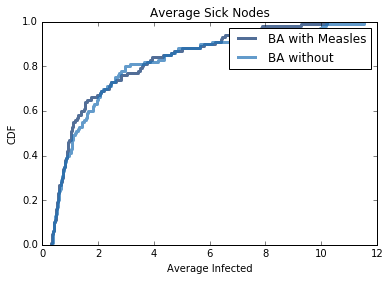

In [57]:
# This cell creates a CDF of many runs, comparing measles vs. not-measles.

F, G = create_student_ba_graph(roommate = False)
iters = 50
total = 100

# maxG, avgG, maxF, avgF = run_trials_same_graph(G.copy(),F.copy(),iters,total) #Can replace with different graphs as-needed.

# thinkplot.Cdf(thinkstats2.Cdf(avgG), label="BA with Measles")
# thinkplot.Cdf(thinkstats2.Cdf(avgF), label="BA without")
# thinkplot.config(xlabel='Average Infected', ylabel='CDF',title="Average Sick Nodes")

maxG, avgG, maxF, avgF = run_trials_different_graphs()
thinkplot.Cdf(thinkstats2.Cdf(avgG), label="BA with Measles")
thinkplot.Cdf(thinkstats2.Cdf(avgF), label="BA without")
thinkplot.config(xlabel='Average Infected', ylabel='CDF',title="Average Sick Nodes")

#TODO: Look into the code here. When cleaning up the .ipynb, I believe I may have messed something up, since this script returns a CDF of two more-or-less identical runs (e.g., no differentiation between measles and not). Consider looking into git history as well.

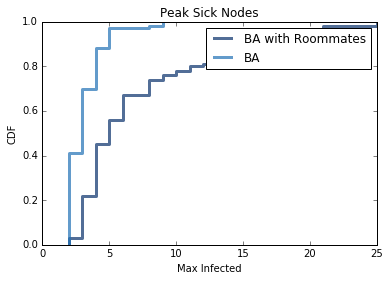

In [60]:
# This cell creates a CDF of many runs, comparing roommate vs. not-roommate.
F = create_student_ba_graph()[0]
G = F.copy()
G = create_Roommates(G)

a,b,c,d = run_trials_same_graph(G,F,50,100)
thinkplot.Cdf(thinkstats2.Cdf(a), label="BA with Roommates")
thinkplot.Cdf(thinkstats2.Cdf(c), label="BA")
thinkplot.config(xlabel='Max Infected', ylabel='CDF',title="Peak Sick Nodes")

# thinkplot.Cdf(thinkstats2.Cdf(b), label="BA with Roomates")
# thinkplot.Cdf(thinkstats2.Cdf(d), label="BA")
# thinkplot.config(xlabel='Average Infected', ylabel='CDF',title="Average Sick Nodes")